In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Uses waveform.py and horn_response.py to plot horn measurement data.

Created on Fri Aug 19 07:51:41 2022

@author: zackashm
"""

# Path set up
from pathlib import Path
HERE = Path('/home/william/Downloads/PUEO/will_antennas/').absolute()

# for quick importing reasons
import os
os.chdir(HERE)


# now import safely
import some_functions as sf
from waveform import waveform
from antenna_response import antenna_response as aresp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.constants import c
from scipy import interpolate, fft
import antennas

mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18
mpl.rcParams['axes.labelsize']=24
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['patch.linewidth']=3
mpl.rcParams['legend.fontsize']=14
mpl.rcParams['axes.titlesize']=24
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['figure.figsize'] = 16, 8
mpl.rcParams['font.family'] = 'sans-serif'

In [19]:
def calc_imp_resp_vs_angle(horn_data):
    out_arr = []
    for ang in [0,10,20,30,40,50,60,70,80,90]:
        dist = 10.5

        angle_data = horn_data.get_data_ang(angle=ang)
        
        fHz, pfft, _ = horn_data.pulse.calc_fft()
        _, sfft, _ = angle_data.calc_fft()
        phys = (dist * c) / (1j * fHz)

        fGHz_ordered = np.fft.fftshift(fHz)*1e-9
        fGHz_pos = fGHz_ordered[fGHz_ordered > 0]

        lowband1 = np.logical_and( 0<=fGHz_pos, fGHz_pos<0.15 )
        lowband2 = np.logical_and( 0.15<=fGHz_pos, fGHz_pos<0.3 )
        withinband = np.logical_and( 0.3<=fGHz_pos, fGHz_pos<=1.2 )
        aboveband1 = np.logical_and( 1.2<fGHz_pos, fGHz_pos<1.35 )
        aboveband2 = np.logical_and( 1.35<=fGHz_pos, fGHz_pos<np.inf )

        below1 = np.ones(len(fGHz_pos[lowband1]))
        below2 = np.linspace(1,1000,len(fGHz_pos[lowband2]),endpoint=True)
        within = 1000*np.ones(len(fGHz_pos[withinband]))
        above1 = np.linspace(1000,1,len(fGHz_pos[aboveband1]),endpoint=True)
        above2 = np.ones(len(fGHz_pos[aboveband2]))

        snr_pos = np.hstack((below1, below2, within, above1, above2))
        # snr = np.hstack((below1, below2, within, above1, above2))
        snr = np.hstack((snr_pos,np.flip(snr_pos)))

        pfft_eff = pfft / phys
        gfft = (1 / pfft_eff) * (1 / (1 + 1 / (np.abs(pfft_eff)**2 * snr)))
        IRfft2w = gfft * sfft

        # unwrap phase to take the sqrt

        IRfft2magw = np.abs(IRfft2w)
        IRfft2phiw = np.angle(IRfft2w)
        IRfft2phiunwrappedw =  np.unwrap(IRfft2phiw, period=np.pi)-np.pi

        # take the sqrt (half of the phase)

        phasesw = 0.5 * IRfft2phiunwrappedw
        #phasesw = (phasesw + np.pi) % (2 * np.pi) - np.pi  # wrap again (do we need to do this?)
        IRfftw = np.sqrt(IRfft2magw) * np.exp(1j * phasesw)

        #IRfftw = np.sqrt(IRfft2w)
        #print(np.angle(IRfftw)[0:30])
        IRfftw = np.insert(IRfftw, 0, 0)
        imp_resp = np.fft.fftshift(np.fft.ifft(IRfftw))
        #plot_imp_resp(horn_data, imp_resp)
        dt = horn_data.signals[0].samplerate
        imp_resp_t = [dt*i*1e9-20 for i in range(len(imp_resp))]
        out_arr.append([imp_resp_t, imp_resp])

    out_arr = np.array(out_arr)
    return out_arr

def standardize_imp(imp_resp_vs_angle, std_ts):
    stdlist = []
    for i in range(0,10):
        imp = imp_resp_vs_angle[i]
        imp_ts = np.real(imp[0]*1e-9)
        imp_hs = np.real(imp[1])

        new_hs = interpolate.interp1d(imp_ts, imp_hs, bounds_error=False, fill_value=0.0)
        new_imp = new_hs(std_ts)   
        stdlist.append(new_imp)
    return stdlist

def get_imp_fdomain(std_imps, std_ts):
    std_fs = fft.rfftfreq(len(std_ts), d=std_ts[1]-std_ts[0])
    all_imps = []
    for i in range(0,10):
        imp_fdomain = fft.rfft(std_imps[i])
        all_imps.append(imp_fdomain)
    return all_imps, std_fs

def get_gain_vs_angle(horn_data):
    bandGHz = (0.1,2.0)

    outgains = []
    for ang in [0,10,20,30,40,50,60,70,80,90]:
        angle_data = horn_data.get_data_ang(angle=ang)
        pul_fHz, pul_rfft, pul_dB = horn_data.pulse.calc_fft(rfft=True, ignore_DC=True)
        pul_gain = interpolate.interp1d(pul_fHz, pul_dB, assume_sorted=True, bounds_error=True)

        sig_fHz, sig_rfft, sig_dB = angle_data.calc_fft(rfft=True, ignore_DC=True)
        sig_gain = interpolate.interp1d(sig_fHz, sig_dB, assume_sorted=True, bounds_error=True)

        fHz = np.linspace(bandGHz[0]*1e9, bandGHz[1]*1e9, pul_fHz.size, endpoint=True)
        fftsize = fHz.size
        front_dist_m = 8.382
        back_dist_m = 9.845
        ant_dist = np.linspace(front_dist_m, back_dist_m, fftsize)

        friis_term = 20 * np.log10( np.abs((4 * np.pi * ant_dist * fHz) / c ) )

        gains = (sig_gain(fHz) - pul_gain(fHz) + friis_term) /2
        gains = 10.**(gains/10.) #dbi, not dbd?
        gains = interpolate.interp1d(fHz, gains, assume_sorted=True, bounds_error=False, fill_value=0.0)
        outgains.append(gains)
    return outgains

def spline_gain_for_file(for_splining, fileHz):
    outarr = []
    for sp in for_splining:
        evaled = sp(fileHz)
        outarr.append(evaled)
    outarr = np.array(outarr)
    return outarr

In [20]:
# ---------------------------------
# -- FILE PARSING PARAMETERS
# ---------------------------------

from pathlib import Path
#HERE = Path('/home/william/Downloads/Antennas/').absolute()

# for quick importing reasons
import os
os.chdir(HERE)

# data path set up
DATA_DATE = "20220822"
PULSER_DATE = DATA_DATE #"20220816"
DATA_DIR = HERE / 'Data/{}/'.format(DATA_DATE)
print("DATA_DIR", DATA_DIR)
PULSER_DIR = HERE / 'Data/PULSER/{}/'.format(PULSER_DATE)
ALLDATA = np.array([file for file in DATA_DIR.glob('*.csv')] + [file for file in PULSER_DIR.glob('*.csv')])  # list of every data file name
# print("All data paths found: \n", ALLDATA)

# -- Now parse through the files to get the ones you want.
# Here's one way

# regex parsers (.* just means anything)
PULSER = "PULSE.*T1A.*Ch1"
Tx = "U.*"
Rx = "T1A.*"
POL = "VPOL"
DESC = ""
ANGLE = "([A-Z]*)[0-9]+" #"([A-Z]*)[0,30,60,90]"
TRIAL = "001"
TYPE = ".*Ch1"


# put it all together
if DESC == "":
    PARSER = "_".join([Tx,Rx,POL,ANGLE,TRIAL,TYPE])
else:
    PARSER = "_".join([Tx,Rx,POL,DESC,ANGLE,TRIAL,TYPE])

# use some_functions.re_search to regex find the files
# these are both an array of Paths, which you input into horn_response(), or feed each one into waveform()
PULSE_PATH = sf.re_search(PULSER, ALLDATA)
SIGNAL_PATHS = sf.re_search(PARSER, ALLDATA)
print(SIGNAL_PATHS, PULSE_PATH, PARSER)
horn_data = aresp(PULSE_PATH, SIGNAL_PATHS)

DATA_DIR /home/william/Downloads/PUEO/will_antennas/Data/20220822
[PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_0_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_10_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_20_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_30_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_40_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_50_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_60_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_70_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_80_001_Ch1.csv')
 PosixPa

Text(0, 0.5, 'phase($\\tilde{h}(f)$)')

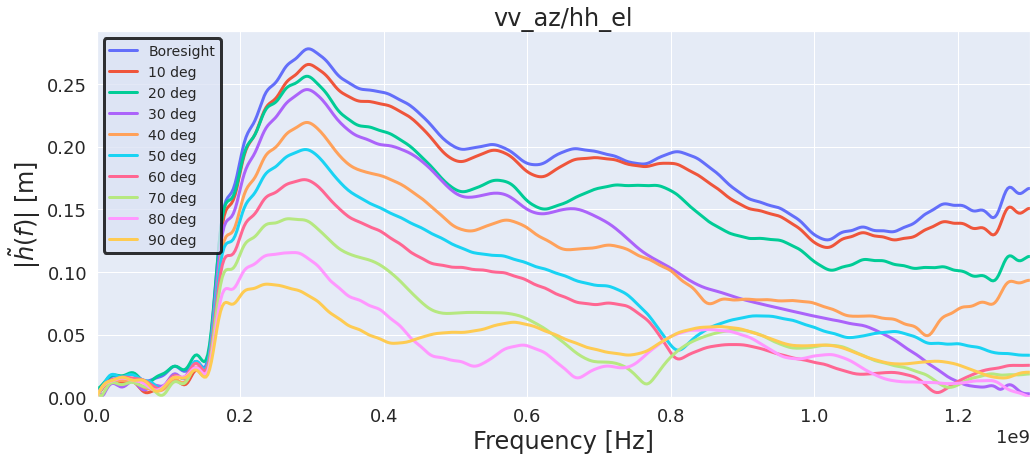

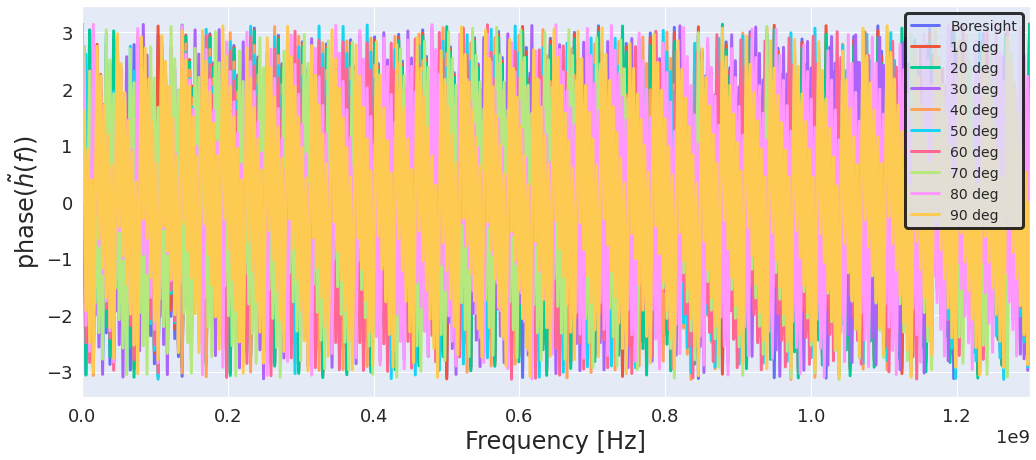

In [21]:
std_ts = np.arange(-1.9692307692307693e-07, 1.9692307692307693e-07, 3.8461538461539315e-10)

imp_resp_vs_angle = calc_imp_resp_vs_angle(horn_data)
std_imps = standardize_imp(imp_resp_vs_angle, std_ts)
std_imps_f, std_fs = get_imp_fdomain(std_imps, std_ts)

impresp_boresight = std_imps_f[0]
impresp_offaxis = std_imps_f/impresp_boresight

f = open("impr_vv_0_Toyon", "w")
for entry in range(0,len(std_fs)):
    f.write("{0} {1} {2}\n".format(std_fs[entry], np.abs(impresp_boresight[entry]), np.angle(impresp_boresight[entry])))
f.close()

concated_offaxis_imp = np.concatenate(impresp_offaxis)
offaxis_hz = np.tile(std_fs, 10)

f = open("impr_hh_el_Toyon", "w")
for entry in range(0,len(offaxis_hz)):
    f.write("{0} {1} {2}\n".format(offaxis_hz[entry], np.abs(concated_offaxis_imp[entry]), np.angle(concated_offaxis_imp[entry])))
f.close()

f = open("impr_vv_az_Toyon", "w")
for entry in range(0,len(offaxis_hz)):
    f.write("{0} {1} {2}\n".format(offaxis_hz[entry], np.abs(concated_offaxis_imp[entry]), np.angle(concated_offaxis_imp[entry])))
f.close()

plt.plot(std_fs, np.abs(impresp_boresight), label='Boresight')
for i in range(1,10):
    angle = i*10
    plt.plot(std_fs, np.abs(impresp_offaxis[i]*impresp_boresight), label='%s deg'%(angle))

plt.ylim(0,)
plt.legend(loc=0)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$|\tilde{h}(f)|$ [m]')
plt.title('vv_az/hh_el')

plt.figure(2)
plt.plot(std_fs, np.angle(impresp_boresight), label='Boresight')
for i in range(1,10):
    angle = i*10
    plt.plot(std_fs, np.angle(impresp_offaxis[i]*impresp_boresight), label='%s deg'%(angle))

plt.legend(loc=1)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'phase($\tilde{h}(f)$)')

In [22]:
# ---------------------------------
# -- FILE PARSING PARAMETERS
# ---------------------------------

from pathlib import Path
#HERE = Path('/home/william/Downloads/Antennas/').absolute()

# for quick importing reasons
import os
os.chdir(HERE)

# data path set up
DATA_DATE = "20220822"
PULSER_DATE = DATA_DATE #"20220816"
DATA_DIR = HERE / 'Data/{}/'.format(DATA_DATE)
print("DATA_DIR", DATA_DIR)
PULSER_DIR = HERE / 'Data/PULSER/{}/'.format(PULSER_DATE)
ALLDATA = np.array([file for file in DATA_DIR.glob('*.csv')] + [file for file in PULSER_DIR.glob('*.csv')])  # list of every data file name
# print("All data paths found: \n", ALLDATA)

# -- Now parse through the files to get the ones you want.
# Here's one way

# regex parsers (.* just means anything)
PULSER = "PULSE.*T1A.*Ch1"
Tx = "U.*"
Rx = "T1A.*"
POL = "HPOL"
DESC = ""
ANGLE = "([A-Z]*)[0-9]+" #"([A-Z]*)[0,30,60,90]"
TRIAL = "001"
TYPE = ".*Ch1"


# put it all together
if DESC == "":
    PARSER = "_".join([Tx,Rx,POL,ANGLE,TRIAL,TYPE])
else:
    PARSER = "_".join([Tx,Rx,POL,DESC,ANGLE,TRIAL,TYPE])

# use some_functions.re_search to regex find the files
# these are both an array of Paths, which you input into horn_response(), or feed each one into waveform()
PULSE_PATH = sf.re_search(PULSER, ALLDATA)
SIGNAL_PATHS = sf.re_search(PARSER, ALLDATA)
print(SIGNAL_PATHS, PULSE_PATH, PARSER)
horn_data = aresp(PULSE_PATH, SIGNAL_PATHS)

DATA_DIR /home/william/Downloads/PUEO/will_antennas/Data/20220822
[PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_HPOL_0_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_HPOL_10_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_HPOL_20_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_HPOL_30_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_HPOL_40_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_HPOL_50_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_HPOL_60_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_HPOL_70_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_HPOL_80_001_Ch1.csv')
 PosixPa

Text(0, 0.5, 'phase($\\tilde{h}(f)$)')

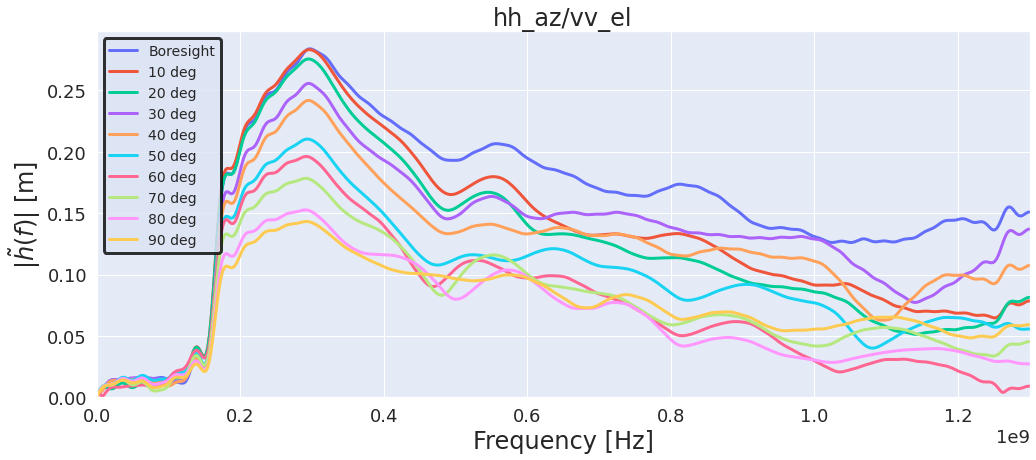

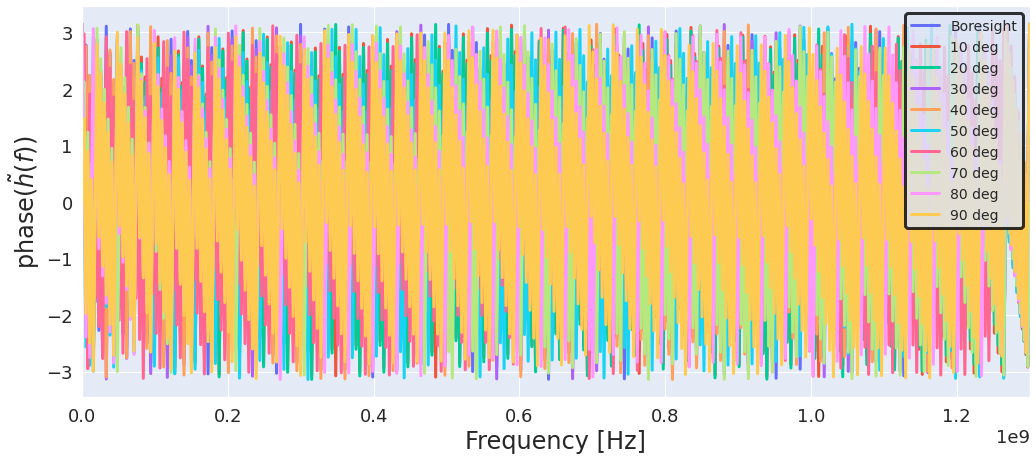

In [23]:
mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18
mpl.rcParams['axes.labelsize']=24
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['patch.linewidth']=3
mpl.rcParams['legend.fontsize']=14
mpl.rcParams['axes.titlesize']=24
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['figure.figsize'] = 16, 8
mpl.rcParams['font.family'] = 'sans-serif'

std_ts = np.arange(-1.9692307692307693e-07, 1.9692307692307693e-07, 3.8461538461539315e-10)

imp_resp_vs_angle = calc_imp_resp_vs_angle(horn_data)
std_imps = standardize_imp(imp_resp_vs_angle, std_ts)
std_imps_f, std_fs = get_imp_fdomain(std_imps, std_ts)

impresp_boresight = std_imps_f[0]
impresp_offaxis = std_imps_f/impresp_boresight

f = open("impr_hh_0_Toyon", "w")
for entry in range(0,len(std_fs)):
    f.write("{0} {1} {2}\n".format(std_fs[entry], np.abs(impresp_boresight[entry]), np.angle(impresp_boresight[entry])))
f.close()

concated_offaxis_imp = np.concatenate(impresp_offaxis)
offaxis_hz = np.tile(std_fs, 10)

f = open("impr_hh_az_Toyon", "w")
for entry in range(0,len(offaxis_hz)):
    f.write("{0} {1} {2}\n".format(offaxis_hz[entry], np.abs(concated_offaxis_imp[entry]), np.angle(concated_offaxis_imp[entry])))
f.close()

f = open("impr_vv_el_Toyon", "w")
for entry in range(0,len(offaxis_hz)):
    f.write("{0} {1} {2}\n".format(offaxis_hz[entry], np.abs(concated_offaxis_imp[entry]), np.angle(concated_offaxis_imp[entry])))
f.close()

plt.plot(std_fs, np.abs(impresp_boresight), label='Boresight')
for i in range(1,10):
    angle = i*10
    plt.plot(std_fs, np.abs(impresp_offaxis[i]*impresp_boresight), label='%s deg'%(angle))

plt.ylim(0,)
plt.legend(loc=0)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$|\tilde{h}(f)|$ [m]')
plt.title('hh_az/vv_el')

plt.figure(2)
plt.plot(std_fs, np.angle(impresp_boresight), label='Boresight')
for i in range(1,10):
    angle = i*10
    plt.plot(std_fs, np.angle(impresp_offaxis[i]*impresp_boresight), label='%s deg'%(angle))

plt.legend(loc=1)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'phase($\tilde{h}(f)$)')

In [24]:
# ---------------------------------
# -- FILE PARSING PARAMETERS
# ---------------------------------

from pathlib import Path
#HERE = Path('/home/william/Downloads/Antennas/').absolute()

# for quick importing reasons
import os
os.chdir(HERE)

# data path set up
DATA_DATE = "20220822"
PULSER_DATE = DATA_DATE #"20220816"
DATA_DIR = HERE / 'Data/{}/'.format(DATA_DATE)
print("DATA_DIR", DATA_DIR)
PULSER_DIR = HERE / 'Data/PULSER/{}/'.format(PULSER_DATE)
ALLDATA = np.array([file for file in DATA_DIR.glob('*.csv')] + [file for file in PULSER_DIR.glob('*.csv')])  # list of every data file name
# print("All data paths found: \n", ALLDATA)

# -- Now parse through the files to get the ones you want.
# Here's one way

# regex parsers (.* just means anything)
PULSER = "PULSE.*T1A.*Ch1"
Tx = "U.*"
Rx = "T1A.*"
POL = "VPOL"
DESC = ""
ANGLE = "([A-Z]*)[0-9]+" #"([A-Z]*)[0,30,60,90]"
TRIAL = "001"
TYPE = ".*Ch2"


# put it all together
if DESC == "":
    PARSER = "_".join([Tx,Rx,POL,ANGLE,TRIAL,TYPE])
else:
    PARSER = "_".join([Tx,Rx,POL,DESC,ANGLE,TRIAL,TYPE])

# use some_functions.re_search to regex find the files
# these are both an array of Paths, which you input into horn_response(), or feed each one into waveform()
PULSE_PATH = sf.re_search(PULSER, ALLDATA)
SIGNAL_PATHS = sf.re_search(PARSER, ALLDATA)
print(SIGNAL_PATHS, PULSE_PATH, PARSER)
horn_data = aresp(PULSE_PATH, SIGNAL_PATHS)

DATA_DIR /home/william/Downloads/PUEO/will_antennas/Data/20220822
[PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_0_001_Ch2.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_10_001_Ch2.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_20_001_Ch2.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_30_001_Ch2.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_40_001_Ch2.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_50_001_Ch2.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_60_001_Ch2.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_70_001_Ch2.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_80_001_Ch2.csv')
 PosixPa

Text(0, 0.5, 'phase($\\tilde{h}(f)$)')

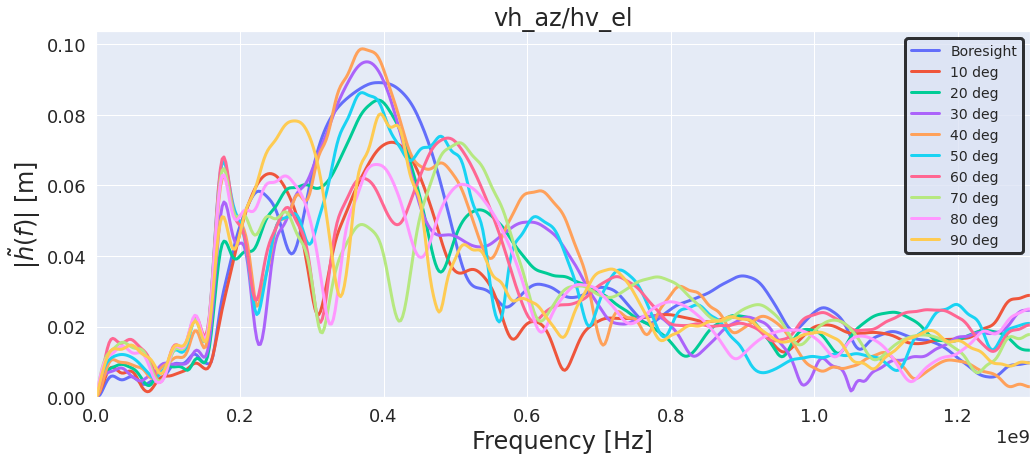

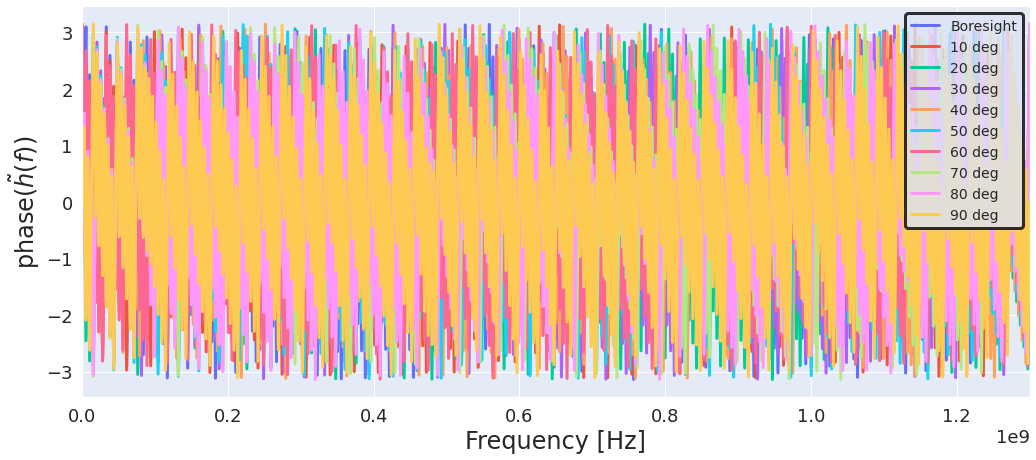

In [25]:
mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18
mpl.rcParams['axes.labelsize']=24
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['patch.linewidth']=3
mpl.rcParams['legend.fontsize']=14
mpl.rcParams['axes.titlesize']=24
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['figure.figsize'] = 16, 8
mpl.rcParams['font.family'] = 'sans-serif'

std_ts = np.arange(-1.9692307692307693e-07, 1.9692307692307693e-07, 3.8461538461539315e-10)

imp_resp_vs_angle = calc_imp_resp_vs_angle(horn_data)
std_imps = standardize_imp(imp_resp_vs_angle, std_ts)
std_imps_f, std_fs = get_imp_fdomain(std_imps, std_ts)

impresp_boresight = std_imps_f[0]
impresp_offaxis = std_imps_f/impresp_boresight

f = open("impr_vh_0_Toyon", "w")
for entry in range(0,len(std_fs)):
    f.write("{0} {1} {2}\n".format(std_fs[entry], np.abs(impresp_boresight[entry]), np.angle(impresp_boresight[entry])))
f.close()

f = open("impr_hv_0_Toyon", "w")
for entry in range(0,len(std_fs)):
    f.write("{0} {1} {2}\n".format(std_fs[entry], np.abs(impresp_boresight[entry]), np.angle(impresp_boresight[entry])))
f.close()

plt.plot(std_fs, np.abs(impresp_boresight), label='Boresight')
for i in range(1,10):
    angle = i*10
    plt.plot(std_fs, np.abs(impresp_offaxis[i]*impresp_boresight), label='%s deg'%(angle))

plt.ylim(0,)
plt.legend(loc=0)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$|\tilde{h}(f)|$ [m]')
plt.title('vh_az/hv_el')

plt.figure(2)
plt.plot(std_fs, np.angle(impresp_boresight), label='Boresight')
for i in range(1,10):
    angle = i*10
    plt.plot(std_fs, np.angle(impresp_offaxis[i]*impresp_boresight), label='%s deg'%(angle))

plt.legend(loc=1)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'phase($\tilde{h}(f)$)')